In [1]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

### Understanding the Dataset
We can read our Parquet dataset through Panda's read_parquet() method, which takes a path to the datafile as an argument.

We preview the first five entires of the dataset with `df.head()`.

In [2]:
df = pd.read_parquet('./dataset.parquet')
df.head()

,url,vec,contents
0,1stwebdesigner.com/free-wordpress-portfolio-pl...,"[0.06221233308315277, -0.027142951264977455, 0...",Top 10 Free WordPress Portfolio Plugins - 1stW...
1,3boysandadog.com/14-fun-pig-craft-projects-for...,"[0.053764428943395615, 0.10884478688240051, 0....",26 Fun & Easy Pig Craft Projects for Kids. Whe...
2,975kgkl.com/listen-live/popup,"[-0.43707162141799927, 0.1012381836771965, 0.4...",KGKL 97.5 FM Country - Listen Live. Listen liv...
3,9news.com/article/entertainment/music/colorado...,"[-0.011343298479914665, -0.29037919640541077, ...",Backstreet Boys will bring DNA World Tour back...
4,9to5toys.com/2022/04/07/best-ios-app-deals-dea...,"[-0.07137802243232727, 0.02366500347852707, 0....","Todays best Mac and iOS app deals: Dead Cells,..."


The output shows three headings for each entry: `url`, `vec`, `contents`. The presence of a URL indicates that each row represents some web page, with each web page having a vector embedding as well a description of the contents of the web page.

### Representing the Dataset in Two Dimensions
To visualise the vectors in our dataset, we will plot them in a two-dimensional space.

Since our DataFrame elements are stored in a column, we need to transpose this into a format understood by Scikit-Learn, which is a NumPy row vector.

PCA is our algorithm of choice to reduce dimensionality, it aims to represent our high-dimensional vector at a lower dimension. After we reduce dimensionality, we can plot our result in a two-dimensional space with Matplotlib.

In [3]:
# Columnar vectors transpose to NumPy row vectors
vectors = df['vec']
np_vectors = np.stack(vectors.values)

print(f'Shape: {np_vectors.shape}')

Shape: (20362, 768)


The output shows that each datapoint in the dataset has 768 dimensions and there are 20362 datapoints.

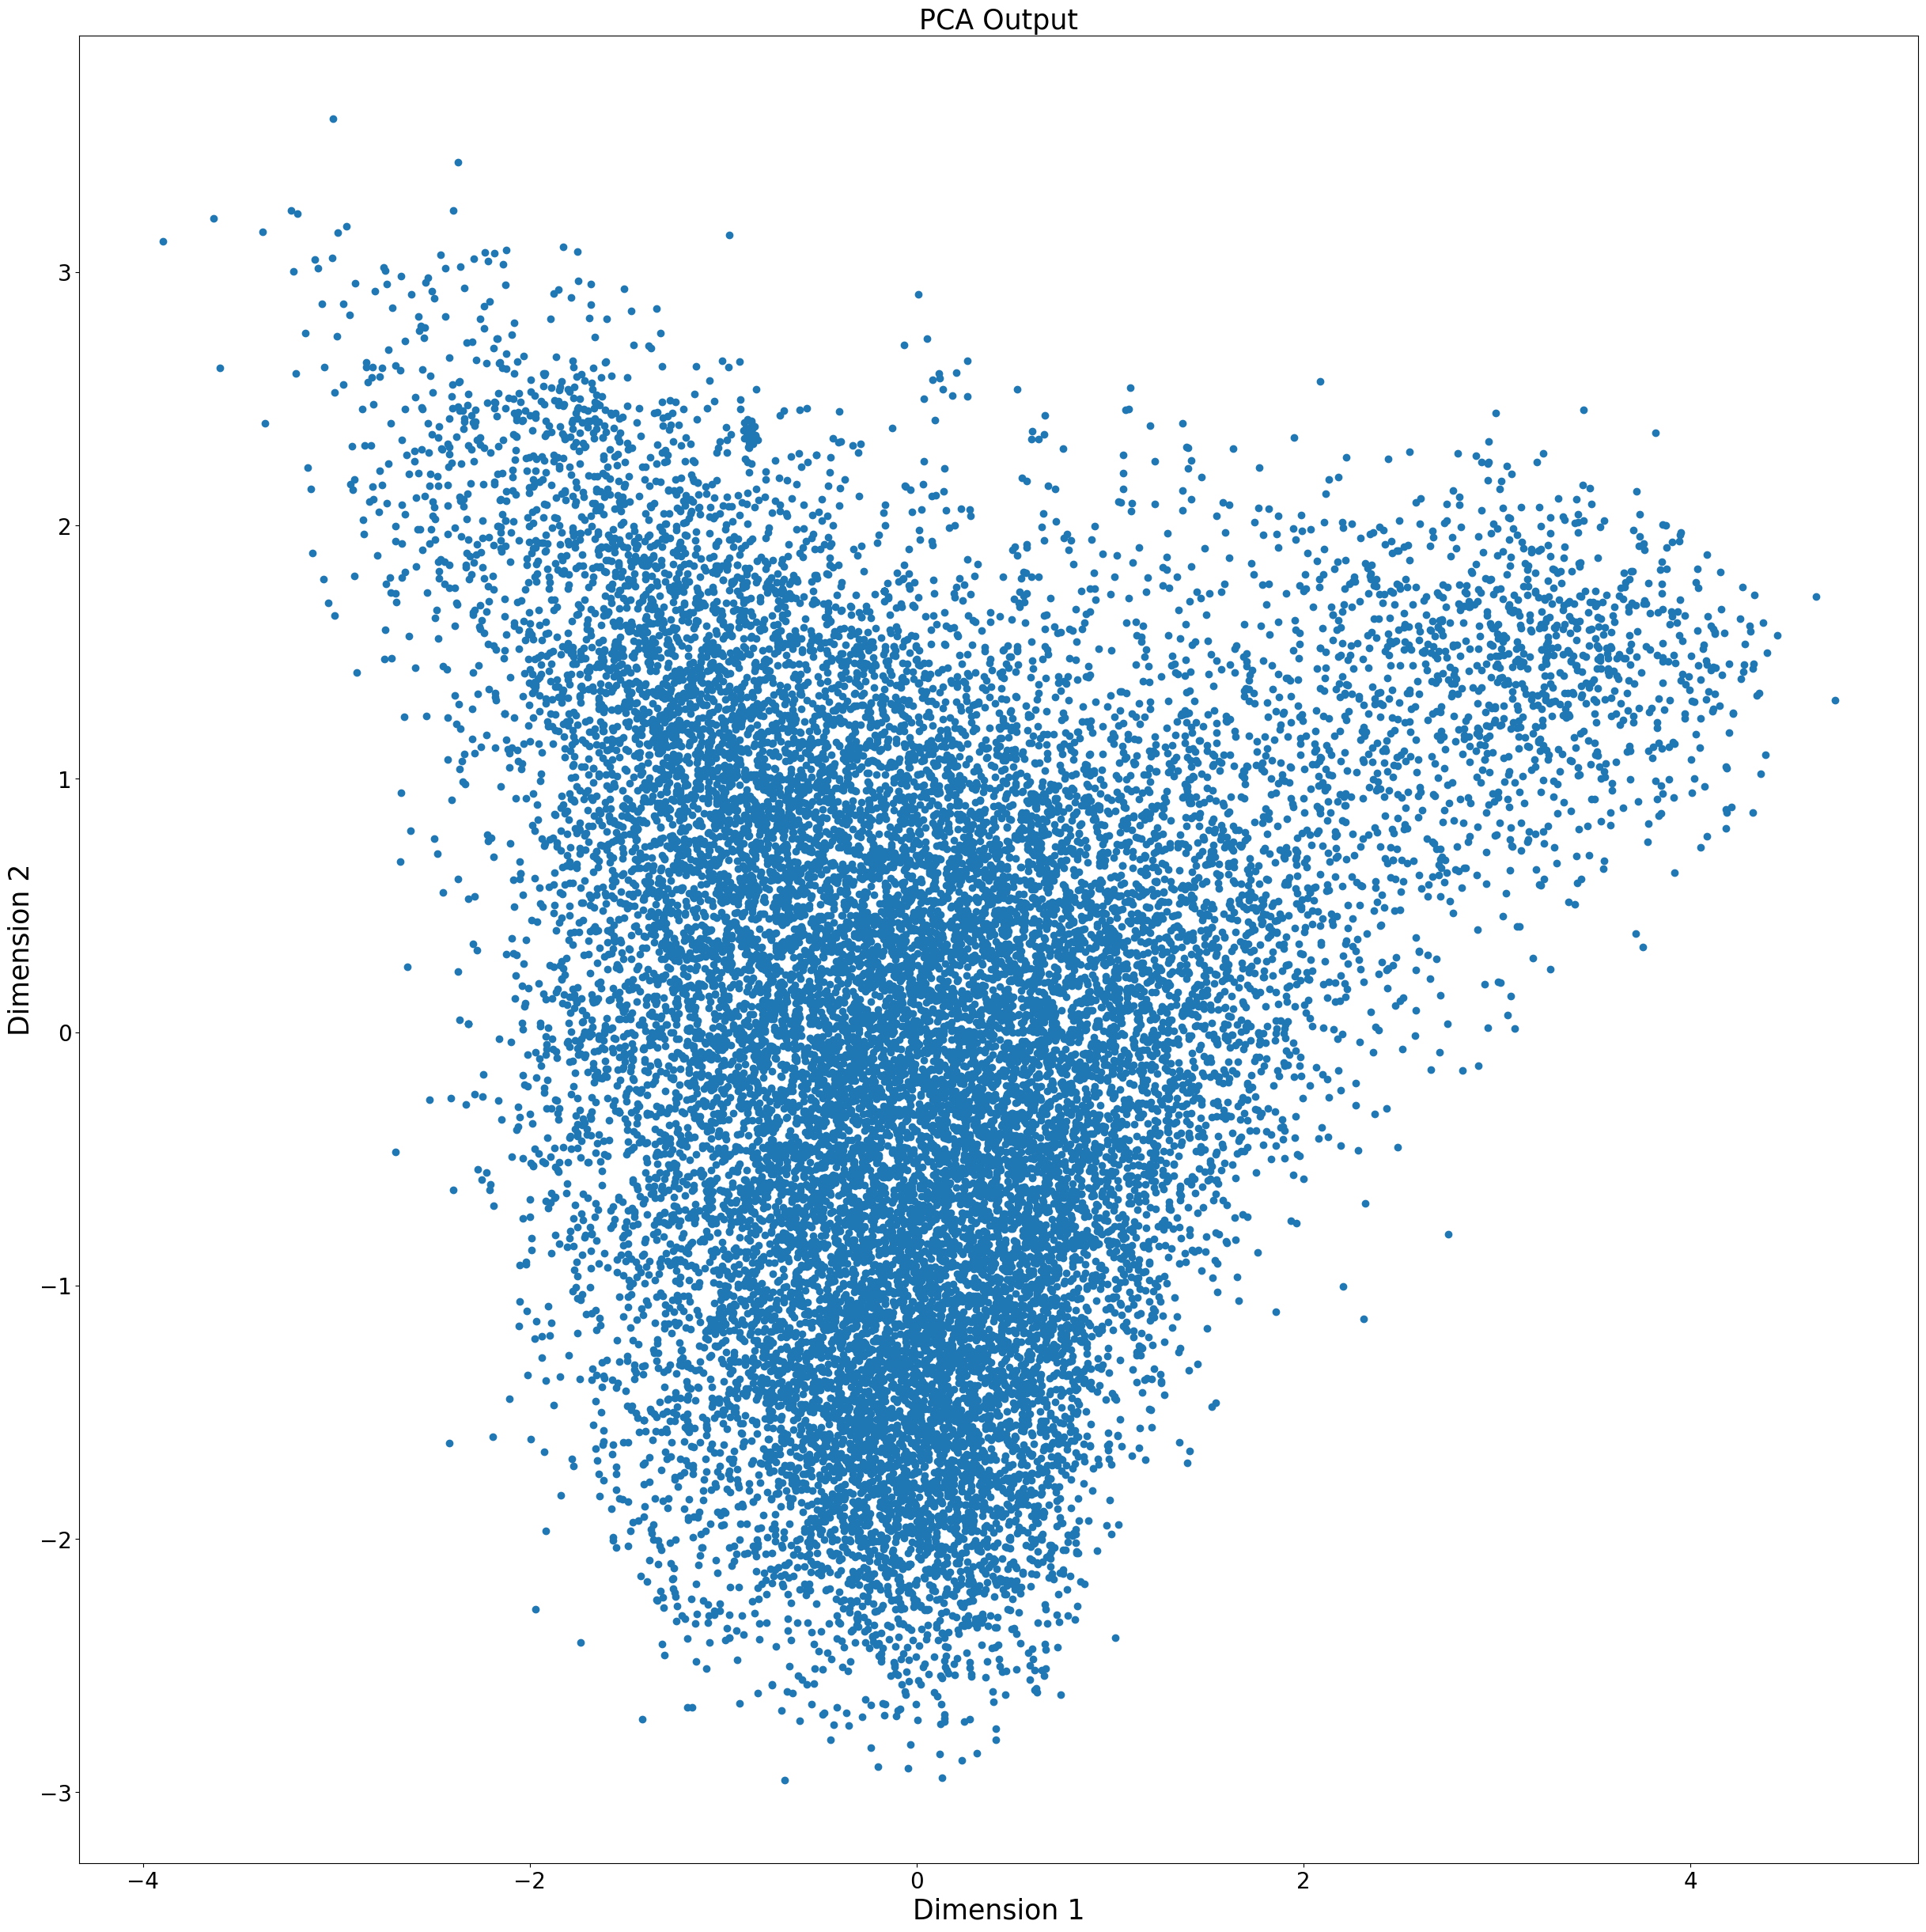

In [4]:
# PCA to reduce dimensionality
pca = PCA(n_components=2) # n_components representing dimensions
reduced_np_vectors = pca.fit_transform(np_vectors)

# Plot the reduced vectors
plt.figure(figsize=(30, 30))
plt.scatter(reduced_np_vectors[:, 0], reduced_np_vectors[:, 1])
plt.xlabel('Dimension 1', fontsize=25)
plt.ylabel('Dimension 2', fontsize=25)
plt.title('PCA Output', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()

The result does not indicate any separability in the dataset in two dimensions. However, this does not mean there is no separabality in higher dimensions. Despite this, we can make out some useful information from the plot. There appears to be three distinct segments in the two-dimensional space within our data (top-left, top-right, and bottom).

The aim will be to form clusters which can represent these segments with the hypothesis that each cluster has a common description, allowing us to categorise web pages.

### Determining the Number of Clusters
Although there appears to be three segments in the two-dimensional space, it could be that there are more separable segments present in a higher-dimension space. We can use the K-Means algorithm to form $k$ clusters (i.e. segments) and to determine the optimal value of $k$, we will use the Elbow Plot. The Elbow Plot runs the K-means algorithm from $k = 1, ..., n$ (for some $n > 0$) and computes the total variance within clusters at each value of $k$. The goal of the elbow plot is to find an inflection point on the curve where adding more clusters cannot be justified by the decrease in variance.

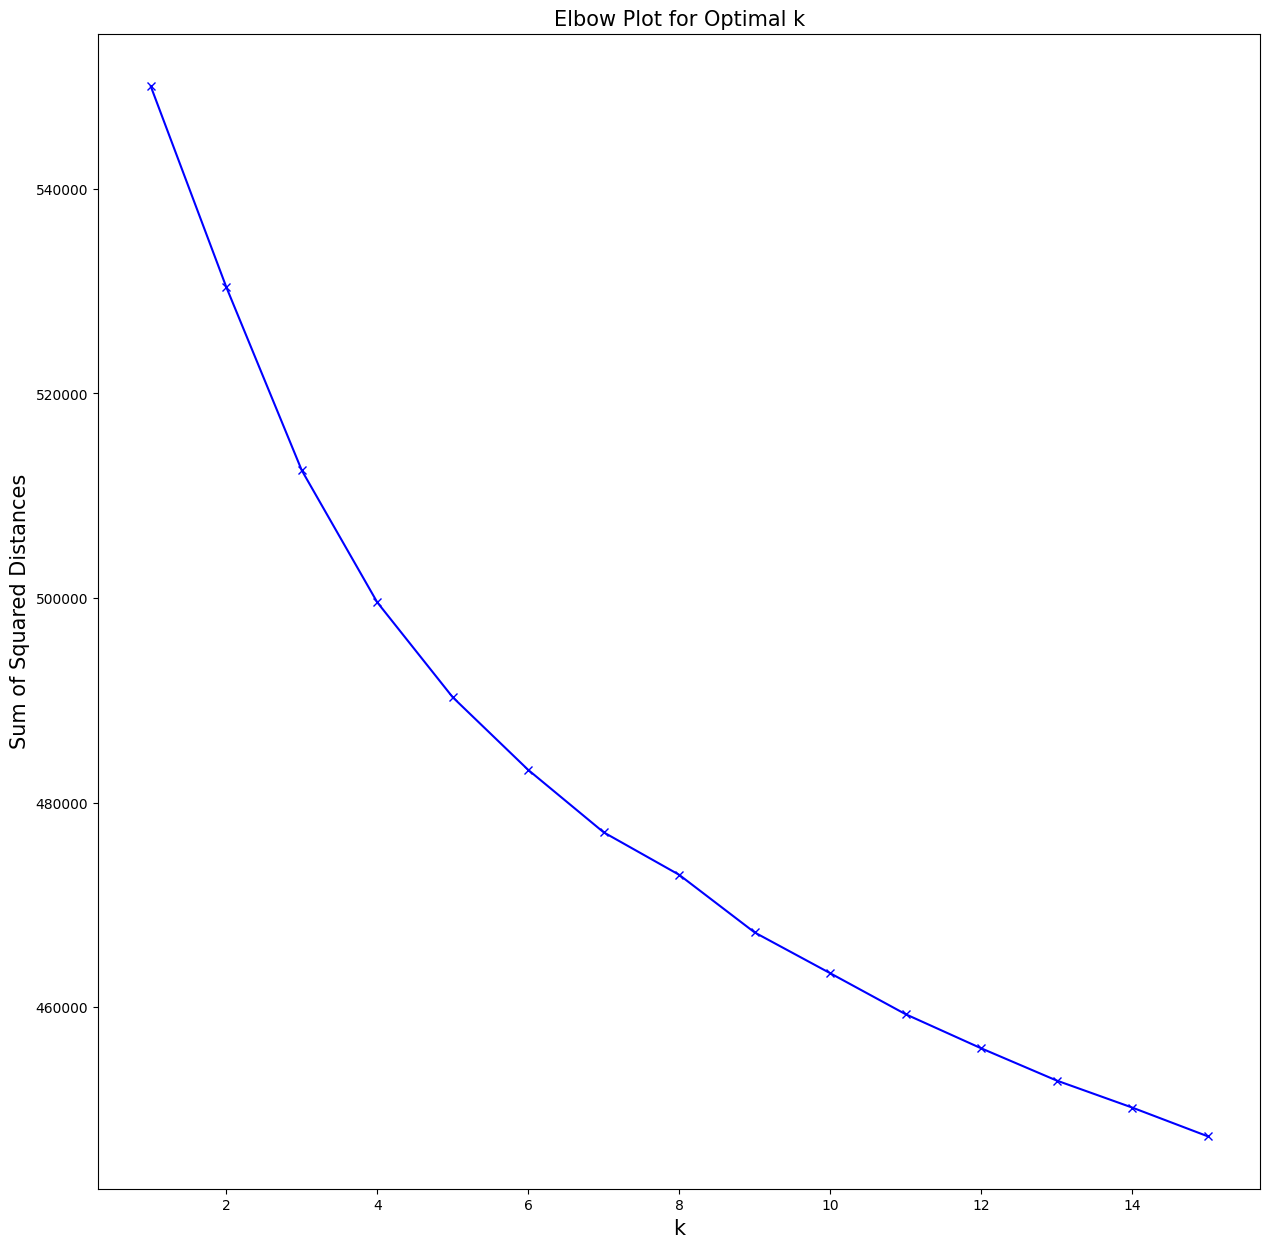

In [5]:
# Determine WCSS for each value of K
sum_of_squared_distances = []
K = range(1, 16) # Limit K to 15
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(np_vectors)
    sum_of_squared_distances.append(km.inertia_)

# Plot the Elbow Plot
plt.figure(figsize=(15, 15))
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k', fontsize=15)
plt.ylabel('Sum of Squared Distances', fontsize=15)
plt.title('Elbow Plot for Optimal k', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.show()

To find the inflection point of this plot, we find a point of diminishing returns, such that 'Sum of Squared Distances' is reduced minimally as $k$ increases (from that point onwards). Visually, think of the line as an arm and try to find the elbow.

For this graph, it will typically be from $k = 4$ to $k = 6$, I have tested (in later snippets) various values, and found that $k = 4$ works best.

### Visualising K-Means Clustering

To visualise our clusters, we firstly need to initialise a Scikit-Learn cluster model, defining the number of clusters we need and fit the model to our high-dimensional vectors.

We can then plot a representation of our dataset. We cannot map high-dimensional vectors to two dimensions, so we use our reduced dataset of vectors which we previously initialised. Centroids are also visualised by calling a function which returns the center of the cluster.

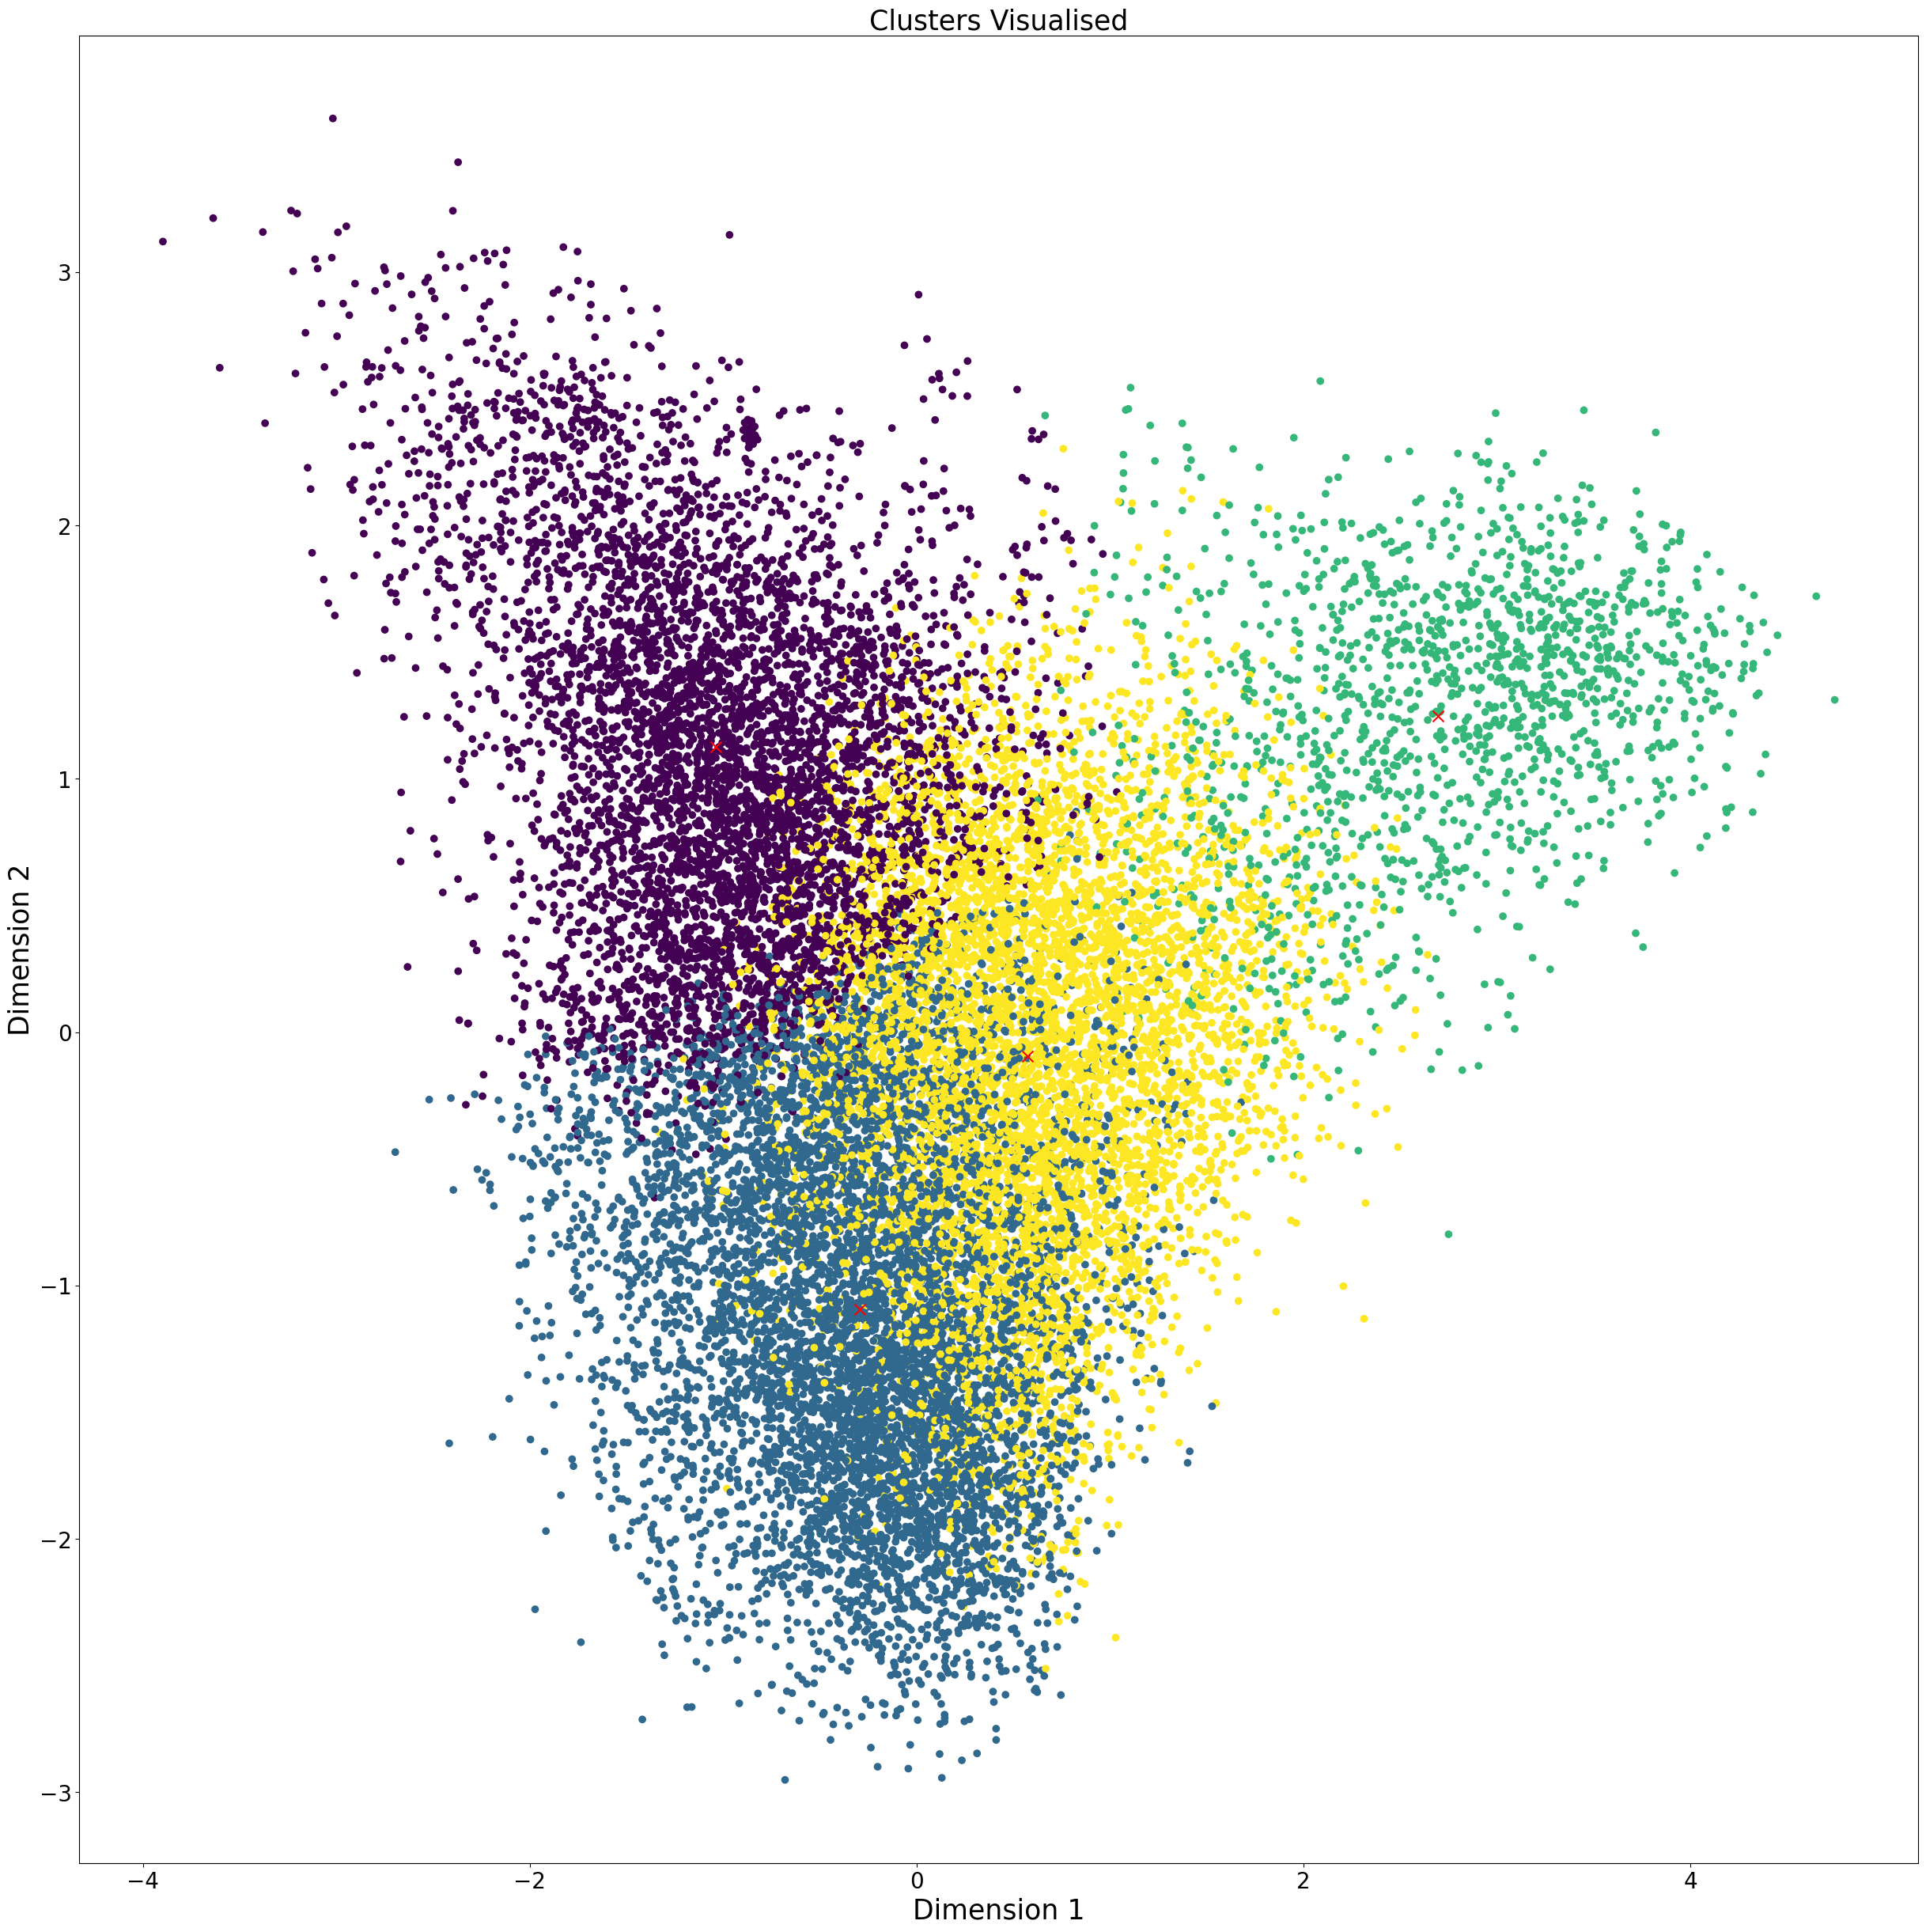

In [6]:
# Clustering
kmeans = KMeans(n_clusters=4) # Number of clusters
kmeans.fit(np_vectors)
labels = kmeans.labels_

# Plotting our clusters
plt.figure(figsize=(30, 30))
plt.scatter(reduced_np_vectors[:, 0], reduced_np_vectors[:, 1], c=labels, cmap='viridis', marker='o')

# Plotting our centroids
centroids = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=100, c='red')

plt.xlabel('Dimension 1', fontsize=25)
plt.ylabel('Dimension 2', fontsize=25)
plt.title('Clusters Visualised', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()

The output shows our dataset split into four clusters, the clusters are formed in the higher-dimensional space and visualised in the 2D space. Top-right is the most distinct, where it has fewer datapoints converging into other clusters (and hence it will be easier to identify, see later).

Note that the clusters overlap because of the dimension reduction we did to our vectors. If we could visualise this data in the original dimension, there would be clear distinctions between clusters where a datapoint from one cluster would not cross the boundary of another cluster.

### Understanding Data in Clusters

We want to understand what type of data each cluster will represent. To do this, we iterate over each word represented in each datapoint (through the 'contents' heading) for each cluster, and add each word to a dictionary. Meaningless words (defined in `./stopwords.txt` will be ignored.)

This allows us to sort our dictionary for the most common words in a cluster.

The first step is to extract contents of each cluster into a list.

In [7]:
df['cluster'] = labels
cluster_1 = df[df['cluster'] == 0]['contents'].tolist()
cluster_2 = df[df['cluster'] == 1]['contents'].tolist()
cluster_3 = df[df['cluster'] == 2]['contents'].tolist()
cluster_4 = df[df['cluster'] == 3]['contents'].tolist()

We import our stopwords text file and convert it into a list.

In [8]:
file_path = './stopwords.txt'
with open(file_path, 'r') as file:
    stopwords = {line.strip() for line in file}

For each cluster, we can now increase the count of each word in a dictionary as long as that word is not listed in stopwords.

In [9]:
dict = defaultdict(int)

for content in cluster_1:
    words = content.split()
    for word in words:
        word = word.lower()
        if word not in stopwords and word.isalpha():
            dict[word] += 1

out = sorted(dict.items(), key=lambda item: item[1], reverse=True)[:10] # Out is a list containing top 10 words
print("Most common words in cluster 1:")
for word, count in out:
    print(f"{word}: {count}")

Most common words in cluster 1:
free: 1017
best: 994
find: 863
download: 520
online: 516
new: 472
latest: 442
game: 387
android: 362
see: 348


In [10]:
dict = defaultdict(int)

for content in cluster_2:
    words = content.split()
    for word in words:
        word = word.lower()
        if word not in stopwords and word.isalpha():
            dict[word] += 1

out = sorted(dict.items(), key=lambda item: item[1], reverse=True)[:10]
print("Most common words in cluster 2:")
for word, count in out:
    print(f"{word}: {count}")

Most common words in cluster 2:
new: 1104
news: 681
april: 430
best: 336
school: 323
city: 318
first: 314
state: 297
high: 273
top: 269


In [11]:
dict = defaultdict(int)

for content in cluster_3:
    words = content.split()
    for word in words:
        word = word.lower()
        if word not in stopwords and word.isalpha():
            dict[word] += 1

out = sorted(dict.items(), key=lambda item: item[1], reverse=True)[:10]
print("Most common words in cluster 3:")
for word, count in out:
    print(f"{word}: {count}")

Most common words in cluster 3:
recipe: 745
easy: 371
chicken: 306
best: 229
food: 202
cake: 190
delicious: 174
perfect: 174
recipes: 168
made: 137


In [12]:
dict = defaultdict(int)

for content in cluster_4:
    words = content.split()
    for word in words:
        word = word.lower()
        if word not in stopwords and word.isalpha():
            dict[word] += 1

out = sorted(dict.items(), key=lambda item: item[1], reverse=True)[:10]
print("Most common words in cluster 4:")
for word, count in out:
    print(f"{word}: {count}")

Most common words in cluster 4:
best: 1189
new: 509
find: 434
need: 397
people: 340
learn: 332
help: 328
here: 324
want: 304
take: 284


There are clusters with distinct categories. The cluster containing 'easy', 'recipe', 'chicken' would come under **food**, the cluster containing 'game', 'download', 'android' would come under **technology**, and the cluster containing 'high', 'school', 'state' would come under **education**. However, there is a cluster which contains an amalgamation of categories, possible due to an incorrect value of $k$ (the number of clusters).

### Conclusion
It is apparent that clustering through K-Means has given some desirable outcome. We were able to identify the categories of three clusters, with one being uncertain.